# IBM Streams Kafka sample application

This sample demonstrates how to create a Streams Python application that connects to a Kafka cluster by using a consumer group and uses partitioned parallel processing of fetched messages.

A Kafka cluster is typically setup and configured by an administrator, but it is also possible that you setup a single Kafka broker on a virtual or physical machine by yourself following the instructions on https://kafka.apache.org/quickstart. In this case you know the details, how to connect, and what topics can be used. Otherwise the administrator of the Kafka cluster must provide the required information.

In this notebook, you'll see examples of how to:
 1. [Setup your data connections](#setup)
 1. [Create the consumer application](#create_1)
 1. [Create a simple producer application](#create_2)
 1. [Submit the applications](#launch)
 1. [Connect to the running consumer application to view data](#view)
 1. [Stop the applications](#cancel)

# Overview

**About the sample**

The main goal of the sample is to show how to connect to a Kafka broker and how to create a Kafka consumer group with downstream parallel processing of the fetched messages. A consumer group is mostly used to consume partitioned topics with multiple consumers sharing the partitions. The messages are typically distributed to the partitions by using a *key*. When keyed messages are processed in parallel after reception by a consumer group it is desired to stick the message keys to one channel only. To achieve this, we route the tuples by the key to the parallel channel.

Consuming a single-partition topic with more than one consumer has no advantage as failed consumers are restarted by Streams nearly as quickly as a failover of the single partition to another consumer would take.

For completion of this sample there is also a data generator, which publishes data to the topic.

**How it works**

The Python application created in this notebook is submitted to the IBM Streams service for execution. Once the application is running in the service, you can connect to it from the notebook to retrieve the results.

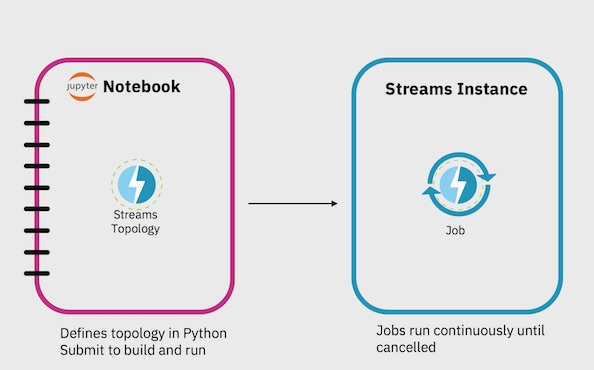


### Documentation

- [Kafka consumer groups](https://kafka.apache.org/documentation/#intro_consumers)
- [Streams Python development guide](https://ibmstreams.github.io/streamsx.documentation/docs/latest/python/)
- [Streams Python API](https://streamsxtopology.readthedocs.io/)
- [streamsx.kafka Python package](https://streamsxkafka.readthedocs.io/)



<a name="setup"></a>
# 1. Setup
### 1.1 Add credentials for the IBM Streams service

In order to submit a Streams application you need to provide the name of the Streams instance.

1. From the navigation menu, click **Services > Instances**.
2. Update the value of `streams_instance_name` in the cell below according to your Streams instance name.

In [ ]:
try:
    from icpd_core import icpd_util
    streams_instance_name = "sample-streams" ## change this to Streams instance

    try:
        cfg=icpd_util.get_service_instance_details(name=streams_instance_name, instance_type="streams")
    except TypeError:
        cfg=icpd_util.get_service_instance_details(name=streams_instance_name)
except ImportError:
    # not on a Cloud Pak for Data?
    cfg = dict()

### 1.2 Import  the `streamsx.kafka` package and verify the package version

In [ ]:
import streamsx.kafka as kafka
import streamsx.topology.context as context
print ("INFO: streamsx package version: " + context.__version__)
print ("INFO: streamsx.kafka package version: " + kafka.__version__)

# need streamsx >= 1.15.0
if int(context.__version__.split('.')[1]) < 15:
    raise ImportError("Your version of streamsx is too old. Please install streamsx >= 1.15.0")

### 1.3 Configure the connection to the Kafka cluster

Kafka consumers and producers are configured by properties. They are described in the Kafka documentation in separate sections for [producer configs](https://kafka.apache.org/23/documentation.html#producerconfigs) and [consumer configs](https://kafka.apache.org/23/documentation.html#consumerconfigs). In Python, you will be using a `dict` variable for the properties.

The operators of the underlying SPL toolkit set defaults for some properties. You can review these operator provided defaults in the [toolkit documentation](https://ibmstreams.github.io/streamsx.kafka/doc/spldoc/html/) under **Operators**.

The most important setting is the `bootstrap.servers` configuration, which is required for both consumers and producers. This config has the form
```
host1:port1,host2:port2,....
```
Since these servers are just used for the initial connection to discover the full cluster membership (which may change dynamically), this list need not contain the full set of servers (you may want more than one, though, in case a server is down).

The required properties for consumers and producers depend on the configuration of the Kafka cluster.
- Connection over TLS, yes or no?
- If TLS is in place, is the server certificate trusted, e.g. signed by a public root CA? If not, you will need the server certificate to configure a truststore.
- Is client or user authentication used?
- If yes, what authentication mechanism is configured?
  Dependent on the authentication mechanism you will need additional secrets, for example username and password, or client certificate and private key.

For example, [AMQ Streams](https://access.redhat.com/products/red-hat-amq#streams), a Kafka cluster for the Openshift container platform, supports encryption with TLS, and authentication using TLS certificates or SCRAM-SHA-512.

Before you begin, you must gather the required connection details. Once you have all information, it is quite comfortable to create the properties for consumers and producers. For the notebook, create a partitioned topic, for example with three partitions or ask the administrator to do this for you.


### 1.3.1 Handling of certificates and keys in the notebook

When you need certificates or keys, you must provide them in PEM format. The PEM format is a text format with base64 coded data enclosed in BEGIN and END anchors. You can add certificates or keys directly to the Python code, for example

    ca_server_cert = """
    -----BEGIN CERTIFICATE-----
    ...
    -----END CERTIFICATE-----
    """

or you can upload certificate and key files as *Data Assets* to your project and use the file names of the local files.

    ca_server_cert = '/project_data/data_asset/<your dataset name>'

In the Kafka cluster, create a partitioned topic, for example with three partitions.

### 1.3.2 When you connect with IBM Event Streams in the public IBM cloud

IBM Event Streams in the public cloud is a fully managed Kafka broker. You connect it by using _service credentials_. You can easily [generate a Kafka configuration from Event Streams service credentials](https://streamsxkafka.readthedocs.io/en/latest/#streamsx.kafka.create_connection_properties_for_eventstreams):


    import streamsx.kafka as kafka
    credentials = ... # either a file name or the credentials JSON as a string
    kafka_config = kafka.create_connection_properties_for_eventstreams(credentials)
    
For example, when you create a data asset `eventstreams.json` in your project that contains the service credentials, you can create a Kafka configuration this way:

    import streamsx.kafka as kafka
    kafka_config = kafka.create_connection_properties_for_eventstreams('/project_data/data_asset/eventstreams.json')
    
This config can be used with the [KafkaConsumer](https://streamsxkafka.readthedocs.io/en/latest/#streamsx.kafka.KafkaConsumer) and [KafkaProducer](https://streamsxkafka.readthedocs.io/en/latest/#streamsx.kafka.KafkaProducer).

<a id="create_1"></a>
# 2. Create the consumer application

This application subscribes to a Kafka topic by using a consumer group (multiple consumers that share a group identifier).

We assume that the messages we fetch from the topic, are JSON formatted with the content like
```
{"sensor_id": "sensor_4545", "value": 3567.87, "ts": 1559029421}
```

All Streams applications start with a Topology object, so start by creating one:

In [ ]:
from streamsx.topology.topology import Topology
from streamsx.topology.context import submit, ContextTypes
from streamsx.topology.topology import Routing
from streamsx.topology.schema import StreamSchema
from streamsx.kafka.schema import Schema
from streamsx.kafka import AuthMethod

consumer_topology = Topology(name='KafkaParallelSample-Consumer', namespace='sample')

## 2.1 Create the consumer properties from your connection details

Use the helper function [create_connection_properties(...)](https://streamsxkafka.readthedocs.io/en/latest/#streamsx.kafka.create_connection_properties) to create the properties.

Dependent on the Kafka cluster configuration you may need
- A trusted server CA certificate
- Information about the authentication method. The function supports following authentication methods:
  - No authentication
  - SASL/PLAIN - you need a username and a password
  - SASL/SCRAM-SHA-512 - you need a username and a password
  - TLS - you need a client certificate and the private key of the certificate.

You always need a topic name that can be accessed. Enter at least the bootstrap servers and the topic name into the below cell.

In [ ]:
topic = "my_topic"  ## change this to an existing topic, it should have multiple partitions
kafka_group_id = "group1"  ## change the consumer group identifier if required
bootstrap_servers = "host.domain:9092"    ## change the bootstrap server(s) here

# this template connects to an unsecured (no TLS) cluster without authentication 
connect_tls = False     # set True when Kafka must be connected with TLS
ca_server_cert = None   # use PEM or filename if required, see section 1.3.1
auth = AuthMethod.NONE  # chose one of NONE, TLS, PLAIN, SCRAM_SHA_512
client_cert = None      # use PEM or filename if auth is TLS
client_priv_key = None  # use PEM or filename if auth is TLS
username = None         # required for PLAIN and SCRAM_SHA_512
password = None         # required for PLAIN and SCRAM_SHA_512


consumer_configs = kafka.create_connection_properties(
    bootstrap_servers=bootstrap_servers,
    use_TLS=connect_tls,      
    enable_hostname_verification=True,
    cluster_ca_cert=ca_server_cert,
    authentication=auth,
    client_cert=client_cert,
    client_private_key=client_priv_key,
    username=username,
    password=password,
    topology=consumer_topology)

# print the consumer configs for reference. Note, that they can contain sensitive data
print()
for key, value in consumer_configs.items():
    print(key + "=" + value)

<div class="alert alert-block alert-warning">
    <b>Warning:</b>
When a certificate or private key is used to create properties, the topology parameter must not be <tt>None</tt>. In this case, the function <tt>create_connection_properties</tt> creates a keystore and/or a truststore file, which are attached as file dependencies to the topology, whereas the filenames go into the created properties.
    
These properties can therefore not be used within a different topology.
</div>

The `group.id` config is not required here. The group identifier is specified on Python API level later. However, when you need other special [consumer configs](https://kafka.apache.org/23/documentation.html#consumerconfigs), you should add them to the `consumer_configs` dict variable here.

## 2.2 Create the consumer group

From the Kafka broker we fetch keyed messages, where the message type is a string. In addition to it we want to fetch the message meta data, like partition number, message timestamp, and other.

That's why we specify `Schema.StringMessageMeta` as the schema for the created Stream in the [kafka.subscribe](https://streamsxkafka.readthedocs.io/en/latest/index.html#streamsx.kafka.subscribe) function.

This schema is a structured schema that defines following attributes:

- message(str) - the message content
- key(str) - the key for partitioning
- topic(str) - the Kafka topic
- partition(int) - the topic partition number (32 bit)
- offset(int) - the offset of the message within the topic partition (64 bit)
- messageTimestamp(int) - the message timestamp in milliseconds since epoch (64 bit)

Create the stream `received` by subscribing to the Kafka topic, parallelize the source by setting the `group_size` greater than 1, and combine the parallel channels with `end_parallel`. The result is a stream created by a consumer group with three consumers.

In [ ]:
from streamsx.kafka import KafkaConsumer
consumer = KafkaConsumer(config=consumer_configs,
                         topic=topic,
                         schema=Schema.StringMessageMeta,
                         group_id=kafka_group_id,
                         group_size=3)

received = consumer_topology.source(consumer, name='SensorSubscribe').end_parallel()

## 2.3 Parallelize message processing with schema transform

Parallelize processing in four parallel channels, routing to the channels is key based, where the key is the `key` attribute from the data stream.


In [ ]:
# start another parallel region partitioned by message key,
# so that each key always goes into the same parallel channel
receivedParallelPartitioned = received.parallel(
    4,
    routing=Routing.KEY_PARTITIONED,
    keys=['key'])

Define a new schema by extending `typing.NamedTuple` and a function that parses the JSON of the messages and maps a couple of attributes of `Schema.StringMessageMeta` to the new schema.

In [ ]:
import json
import typing
class SensorMessage(typing.NamedTuple):
    sensor_id: str
    reading: float
    ts: int                # timestamp of the sensor measurement
    partition: int
    messageTimestamp: int  # timestamp of the Kafka message


# parses the JSON in the message and adds the attributes to a tuple
def parse_json_to_tuple(tuple):
    # the tuple is passed in as dict, the output is a namedTuple
    messageAsDict = json.loads(tuple['message'])
    # as an example, in 'messageAsDict we have
    # {"sensor_id": "sensor_4545", "value": 3567.87, "ts": 1559029421}
    
    # 5 required positional arguments: 'sensor_id', 'reading', 'ts', 'partition', and 'messageTimestamp'
    return SensorMessage(
        messageAsDict['sensor_id'],
        messageAsDict['value'],
        messageAsDict['ts'],
        tuple['partition'],
        tuple['messageTimestamp']
    )


# map the parallelized stream to the new schema
receivedParallelPartitionedParsed = receivedParallelPartitioned.map(
    func=parse_json_to_tuple,
    name='ParseMsgJson',
    schema=SensorMessage)  # tuple passing will be named tuple: class SensorMessage


# validate by removing negative and zero values from the streams,
# pass only positive values and timestamps
receivedValidated = receivedParallelPartitionedParsed.filter(
    # remember, the tuple tup is passed as a Python named tuple, not as a dict
    func=lambda _tuple: (_tuple.reading > 0) and (_tuple.ts > 0),
    name='Validate')


# end parallel processing and (dummy) filter as it is not possible to
# create a view on a combined stream directly
parallelEnd = receivedValidated.end_parallel().filter(lambda x: x)

<a name="create_view"></a>
## 2.4 Create a `View` to preview the tuples on the `Stream` 

A `View` is a connection to a `Stream` that becomes activated when the application is running. We examine the data from within the notebook in [section 5](#view), below.


In [ ]:
streamView = parallelEnd.view(name="ValidatedSensorData",
                              description="Validated Sensor data")

## 2.5 Define output

The `parallelEnd` stream is our final result. We will use `Stream.publish()` to make this stream available to other Streams applications.

If you want to send the stream to another database or system, you would use a sink function and invoke it using `Stream.for_each`. You can also use the functions of other Python packages to send the stream to other systems, for example the eventstore.

In [ ]:
import json
# publish results as JSON
parallelEnd.publish(topic="SensorData",
                    schema=json,
                    name="PublishSensors")

# other options include:
# invoke another sink function:
# parallelEnd.for_each (func=send_to_db)
# parallelEnd.print()

<a id="create_2"></a>
# 3. Create a simple producer application

To make the consumer application work, we need to publish some data to the topic. Therefore we create another, less complicated application that publishes data to the Kafka broker.

## 3.1 Define a data generator for the messages and a source stream

In [ ]:
import random
import time
import json
from datetime import datetime


# define a callable source for data that we publich in Kafka
     
class SensorReadingsSource(object):
    def __call__(self):
        # this is just an example of using generated data, here you could
        # - connect to db
        # - generate data
        # - connect to data set
        # - open a file
        i = 0
        while(i < 500000):
            time.sleep(0.001)
            i = i + 1
            sensor_id = random.randint(1, 100)
            reading = dict()
            reading["sensor_id"] = "sensor_" + str(sensor_id)
            reading["value"] = random.random() * 3000
            reading["ts"] = int(datetime.now().timestamp())
            yield reading

producer_topology = Topology(name='KafkaParallelSample-Producer', namespace='sample')

# create the data and map them to the attributes 'message' and 'key' of the
# 'Schema.StringMessage' schema for Kafka, so that we have messages with keys
sensorStream = producer_topology.source(
    SensorReadingsSource(),
    "RawDataSource"
    ).map(
        func=lambda reading: {'message': json.dumps(reading),
                              'key': reading['sensor_id']},
        name="ToKeyedMessage",
        schema=Schema.StringMessage)

## 3.2 Publish the data to the Kafka topic

For advanced producer configurations please review the [producer configs section](https://kafka.apache.org/21/documentation.html#producerconfigs) of the Kafka documentation. Here we setup only the `bootstrap.servers` as used for the consumers. For a Kafka basic install out of the box this is sufficient. When you have configured authentication or other security options for the consumer, you must configure the same options also for the producer.

### 3.2.1 Create the producer properties from your connection details

We will be using the helper function [create_connection_properties(...)](https://streamsxkafka.readthedocs.io/en/latest/#streamsx.kafka.create_connection_properties), but will use the `producer_topology` variable as the `topology` parameter to get any created keystore or truststore files attached as file dependencies.

<div class="alert alert-block alert-info">
    <b>Info:</b>
We intentionally do not re-use the consumer properties for the producer application. In case we use certificates in any way, we have created consumer configurations that include a keystore or truststore file, which was added as a file dependency to the consumer topology. When we re-used the consumer properties here we would miss the file dependency in the prodcuer topology.
</div>


In [ ]:
from streamsx.kafka import KafkaProducer

producer_configs = kafka.create_connection_properties(
    bootstrap_servers=bootstrap_servers,
    use_TLS=connect_tls,      
    enable_hostname_verification=True,
    cluster_ca_cert=ca_server_cert,
    authentication=auth,
    client_cert=client_cert,
    client_private_key=client_priv_key,
    username=username,
    password=password,
    topology=producer_topology)

# print the producer configs for reference. Note, that they can contain sensitive data
print()
for key, value in producer_configs.items():
    print(key + "=" + value)

sensorStream.for_each(KafkaProducer(config=producer_configs, topic=topic), name='SensorPublish')

<a id="launch"></a>
# 4. Submit both applications to the Streams instance
A running Streams application is called a *job*. By submitting the topologies we create two independent jobs.

In [ ]:
# disable SSL certificate verification if necessary
cfg[context.ConfigParams.SSL_VERIFY] = False

# submit consumer topology as a Streams job
consumer_submission_result = submit(ContextTypes.DISTRIBUTED, consumer_topology, cfg)
consumer_job = consumer_submission_result.job
if consumer_job:
    print("JobId of consumer job: ", consumer_job.id , "\nJob name: ", consumer_job.name)

In [ ]:
# submit producer topology as a Streams job
producer_submission_result = submit(ContextTypes.DISTRIBUTED, producer_topology, cfg)
producer_job = producer_submission_result.job
if producer_job:
    print("JobId of producer job: ", producer_job.id , "\nJob name: ", producer_job.name)

<a name="view"></a>
# 5. Use a `View` to access data from the job
Now that the job is started, use the `View` object you created in [step 2.4](#create_view) to start retrieving data from a `Stream`.

In [ ]:
# connect to the view and display 20 samples of the data
queue = streamView.start_data_fetch()
try:
    for val in range(20):
        print(queue.get(timeout=60))    
finally:
    streamView.stop_data_fetch()

## 5.1 Display the results in real time
Calling `View.display()` from the notebook displays the results of the view in a table that is updated in real-time.

In [ ]:
# display the results for 60 seconds
streamView.display(duration=60)


## 5.2 See job status 


The tools available to monitor the running application depend on the version of Streams and your development environment.

- **If you are using a Cloud Pak for Data 3.5 project:**  When you submit the `Topology`, you create a new <i>job run</i>. The job represents the application and the job run represents a single instance of the running application. 

    1. Open your project and click on the **Jobs** tab. This will show a list of the project's jobs.
    1. Under the **Job name** column, find your job based on the `Job Name` [printed when you submitted the job](#launch). This will list all of the job runs for that job.
    1. Click the **Run name** to open the job run. The run name will be the same as the `Job Name` printed above.
    

- **For all other development environments and versions of Streams**, [see this page for more information](http://ibmstreams.github.io/streamsx.documentation/docs/spl/quick-start/qs-4).
<a name="cancel"></a>

# 6. Cancel the jobs

The Streams jobs are running in the Streams service. You can cancel them within the notebook or delete them from **Projects** > **Jobs**.

In [ ]:
# stop the view's background data fetch in case the 60 seconds display duration are not yet over
streamView.stop_data_fetch()

# cancel the jobs directly using the Job objects
producer_job.cancel()
consumer_job.cancel()

# 7. Congratulation

You created a non-trivial Streams application that connected to a Kafka cluster with a consumer group for load sharing. Then you parallelized the processing of the fetched messages in a way that the keys of the messages were pinned to the parallel channels. Finally you sampled the processed data by using a view, and published the data within the Streams instance, so that other Streams applications in the instance can subscribe to it.

Not to forget, to bring the application to life, you also created a simple producer application, which published artificial sensor data to the Kafka topic.